In [ ]:
import  numpy                           as np
import  pandas                          as pd
import  tensorflow                      as tf
import  matplotlib                      as mpl
import  matplotlib.pyplot               as plt

from    sklearn.base                    import BaseEstimator, ClassifierMixin
from    sklearn.metrics                 import accuracy_score
from    sklearn.preprocessing           import MultiLabelBinarizer, LabelEncoder
from    sklearn.neural_network          import MLPClassifier
from    sklearn.model_selection         import GridSearchCV, StratifiedKFold, train_test_split

from    tensorflow.keras                import Sequential
from    tensorflow.keras.layers         import Input, Dense, Dropout
from    tensorflow.keras.callbacks      import EarlyStopping
from    tensorflow.keras.regularizers   import l2

# Set high-resolution matplotlib plots
mpl.rcParams['figure.dpi'] = 300

### **Data Processing**

In [34]:
# Load dataset
df = pd.read_csv(r'./Dataset/dataset.csv')

In [35]:
symptom_cols = [c for c in df.columns if c.lower().startswith('symptom')]   #gather all the columns that have the name column
#collapse them into a single python list 
df['symptom_list'] = df[symptom_cols].apply(
    lambda row: [
        s.strip()                    # remove leading/trailing spaces If you skip it: You’d end up with duplicates in your classifier—two distinct features called "rash" vs. "rash ".
        for s in row.tolist()        # iterate over the raw values
        if isinstance(s, str)        # skip NaNs (they’re floats)  If you skip it: Your lists will include nan, and MultiLabelBinarizer will treat that as its own “symptom” category.
           and s.strip()             # drop empty strings If you skip it: You’d get "" entries in your lists, again creating bogus “empty” symptom categories
    ],
    axis=1
)


In [36]:
# 1c) Create a sorted tuple “pattern” to identify duplicates
df['pattern'] = df['symptom_list'].apply(lambda L: tuple(sorted(L)))

# 1d) Drop duplicate patterns
uniq = df.drop_duplicates('pattern').reset_index(drop=True)

print(f"Original rows: {len(df)} Unique patterns: {len(uniq)}")

Original rows: 4920 Unique patterns: 304


### **L2 Regularization GridSearch**

X2 shape, dtype: (304, 131) float32
y2_int shape, dtype: (304,) int64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iteration

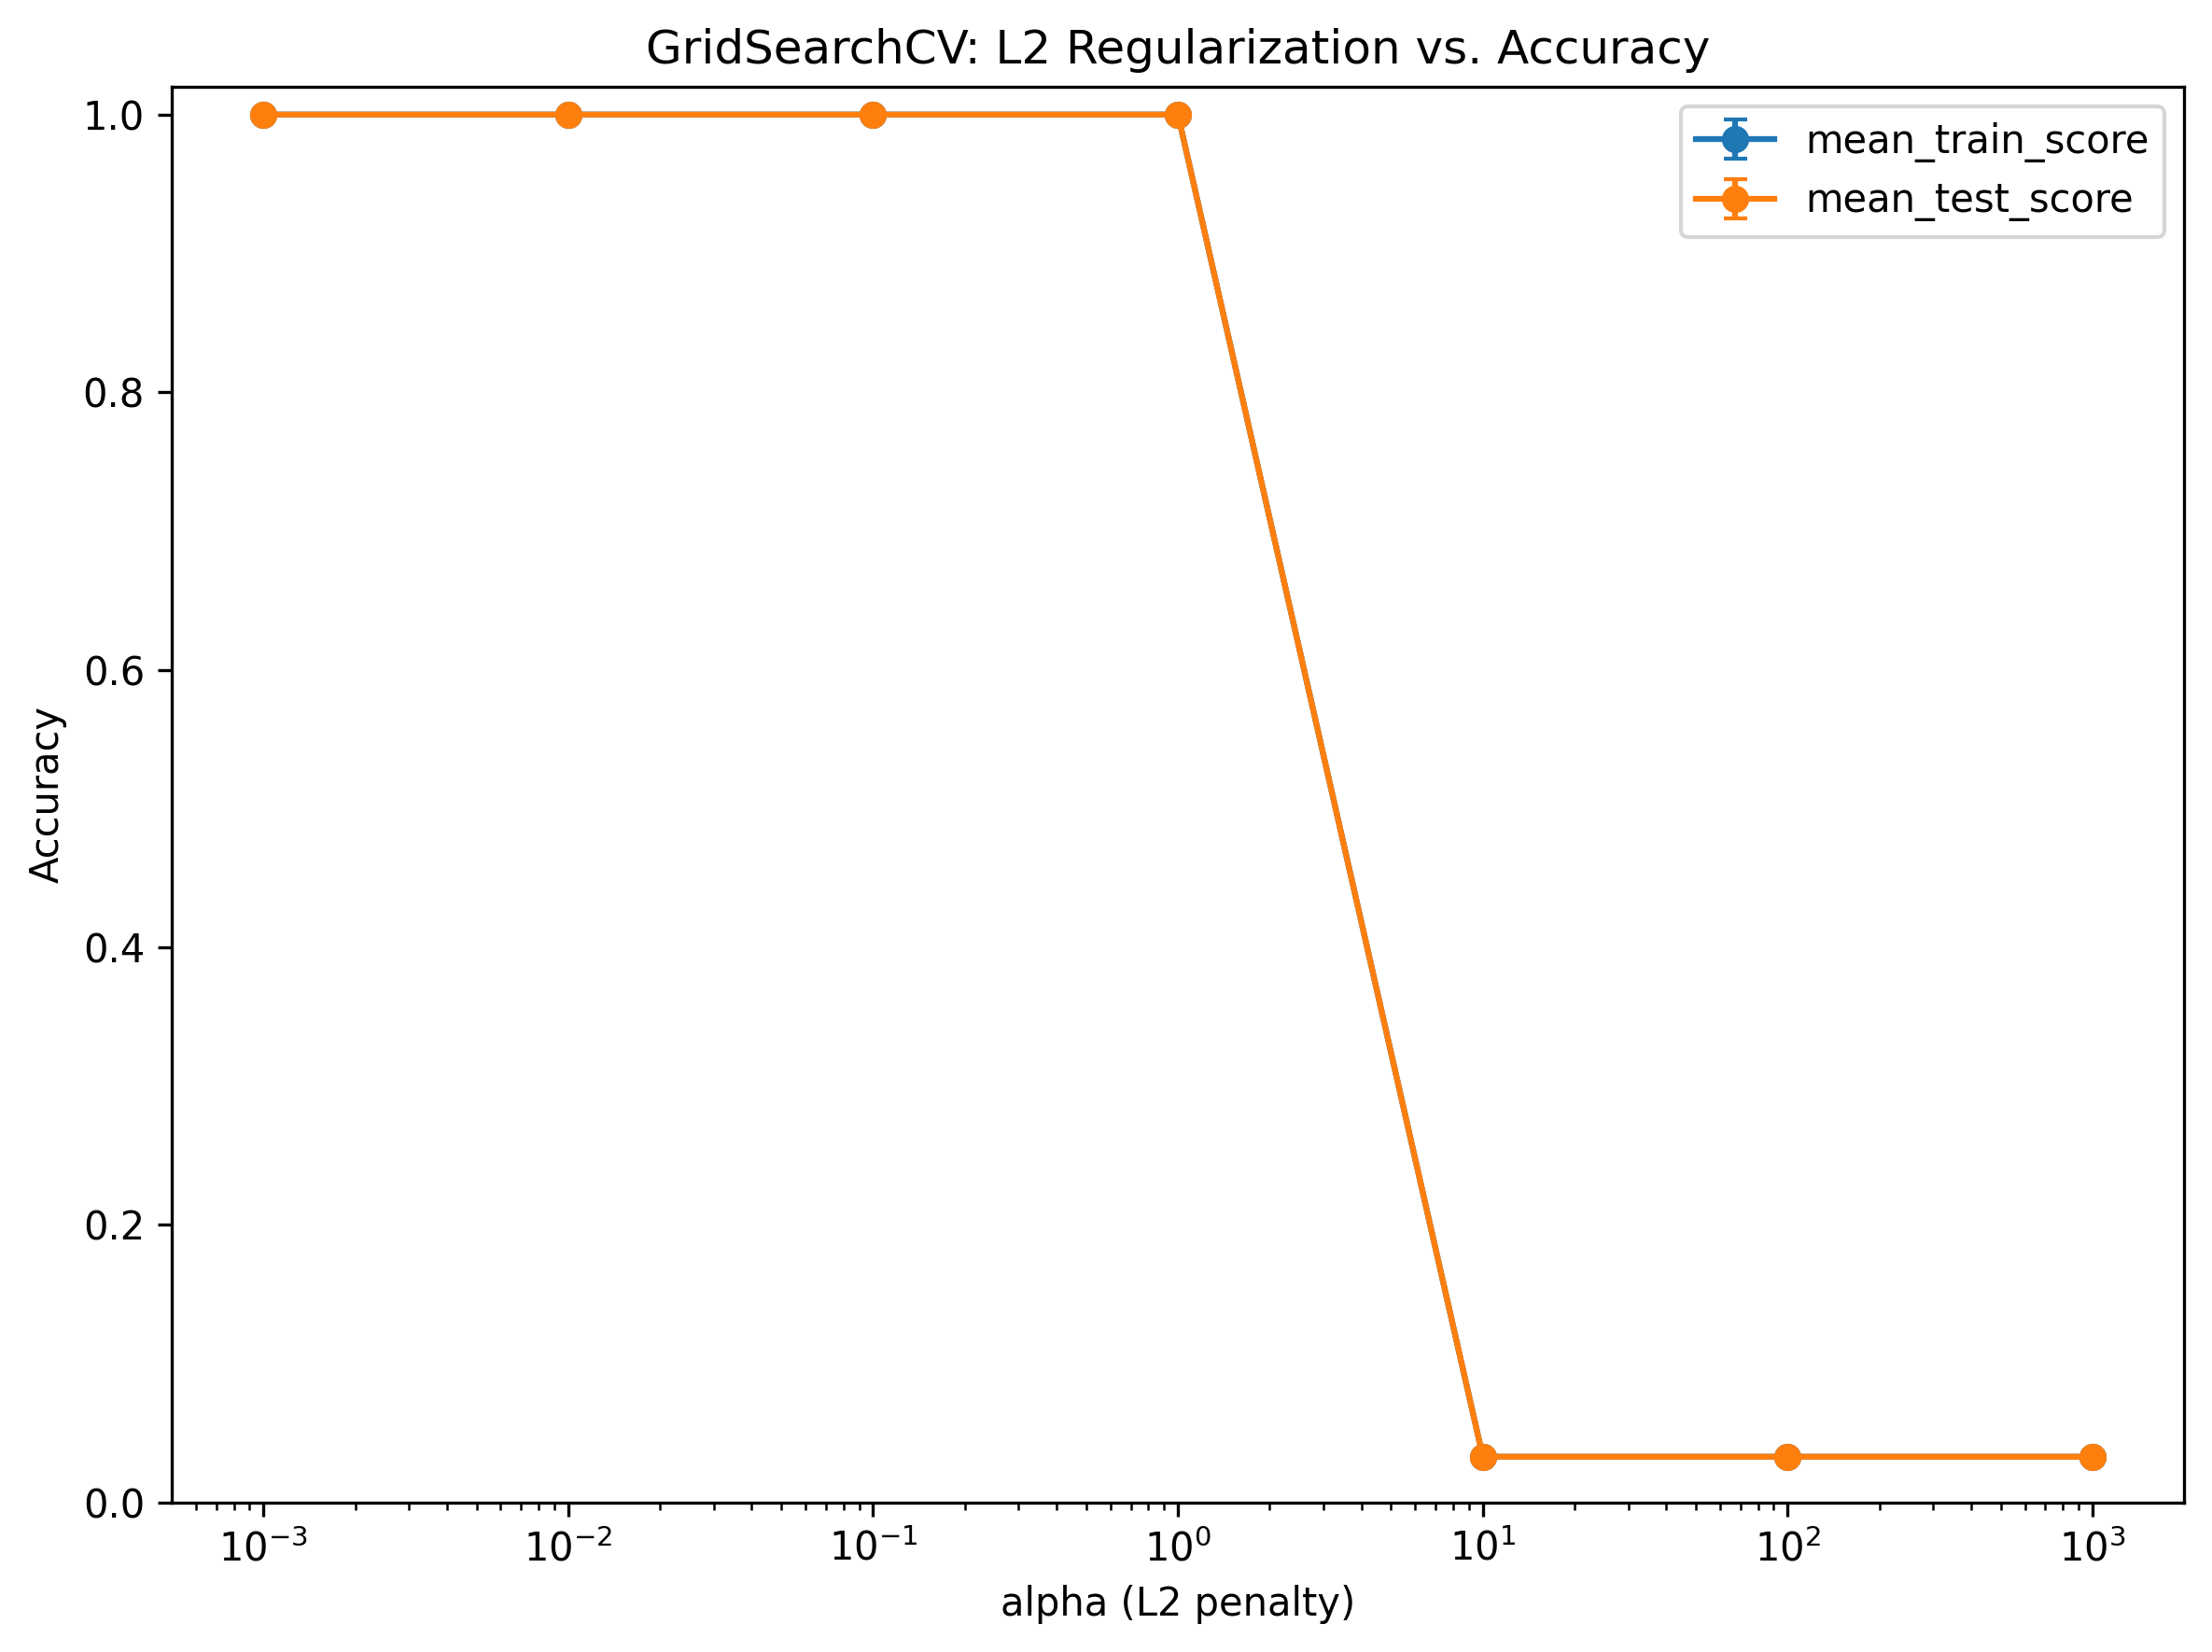

Best alpha: 0.001
Cross-validated accuracy: 1.0000


In [37]:
# ─── 3. Build Feature Matrix X2 & Labels y2_int ──────────────────────────────
# 3a) Binarize symptoms
mlb    = MultiLabelBinarizer()
X2_int = mlb.fit_transform(uniq['symptom_list'])  # int32

# 3b) Encode disease labels to integers
le     = LabelEncoder()
y2_int = le.fit_transform(uniq['Disease'])        # int64 array

# 3c) Cast X2 to float32 (MLPClassifier in sklearn will convert anyway, 
# but this ensures numeric type consistency)
X2 = X2_int.astype('float32')
print("X2 shape, dtype:", X2.shape, X2.dtype)
print("y2_int shape, dtype:", y2_int.shape, y2_int.dtype)

# ─── 4. GridSearchCV over L2 penalty (alpha) ────────────────────────────────
# 4a) Define the range of α to search
alphas = np.logspace(-3, 3, 7)  # 1e-3 → 1e3

# 4b) Configure MLPClassifier to mirror your Keras net (64→32)
mlp = MLPClassifier(
    hidden_layer_sizes=(64,32),
    activation='relu',
    max_iter=200,
    random_state=42
)

# 4c) Set up the grid search (5-fold CV, track both train & test scores)
grid = GridSearchCV(
    estimator=mlp,
    param_grid={'alpha': alphas},
    cv=5,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1
)

# 4d) Run the grid search
grid.fit(X2, y2_int)

# ─── 5. Plot Train vs. Test Accuracy ────────────────────────────────────────
mean_test  = grid.cv_results_['mean_test_score']
std_test   = grid.cv_results_['std_test_score']
mean_train = grid.cv_results_['mean_train_score']
std_train  = grid.cv_results_['std_train_score']

plt.figure(figsize=(8,6))
#plt.errorbar(alphas, mean_train, yerr=std_train,
#             marker='o', capsize=3, label='Avg Train Score')
#plt.errorbar(alphas, mean_test,  yerr=std_test,
#             marker='o', capsize=3, label='Avg Test Score')
plt.plot(alphas, mean_train, 'o-', color='blue', label='Train Accuracy')
plt.plot(alphas, mean_test,  'o-', color='orange', label='Test Accuracy')
plt.xscale('log')
plt.ylim(0.0, 1.02)
plt.xlabel(r'$\alpha$ (L2 Penalty)')
plt.ylabel('Accuracy')
plt.title('GridSearchCV: L2 Regularization vs. Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('./Plots/NeuralNet/l2reg_vs_accuracy.pdf')
plt.show()

# ─── 6. Report Best α ───────────────────────────────────────────────────────
best_alpha = grid.best_params_['alpha']
best_score = grid.best_score_
print(f"Best alpha: {best_alpha}")
print(f"Cross-validated accuracy: {best_score:.4f}")

For $\alpha \leq 1$, both train and test accuracy sit at $100$%, meaning your network is still essentially memorizing (even on deduped patterns) until $\alpha$ gets large enough to under-fit.

As soon as $\alpha$ hits 10, everything collapses toward random. 

The sweet spot is therefore $\alpha = 0.001$, which is the largest penalty that still allows perfect CV accuracy.

### **Dropout Regularization GridSearch**

Dropout 0.2 → CV accuracy: 1.0000 ± 0.0000
Dropout 0.3 → CV accuracy: 0.9967 ± 0.0067
Dropout 0.4 → CV accuracy: 1.0000 ± 0.0000
Dropout 0.5 → CV accuracy: 0.9868 ± 0.0123


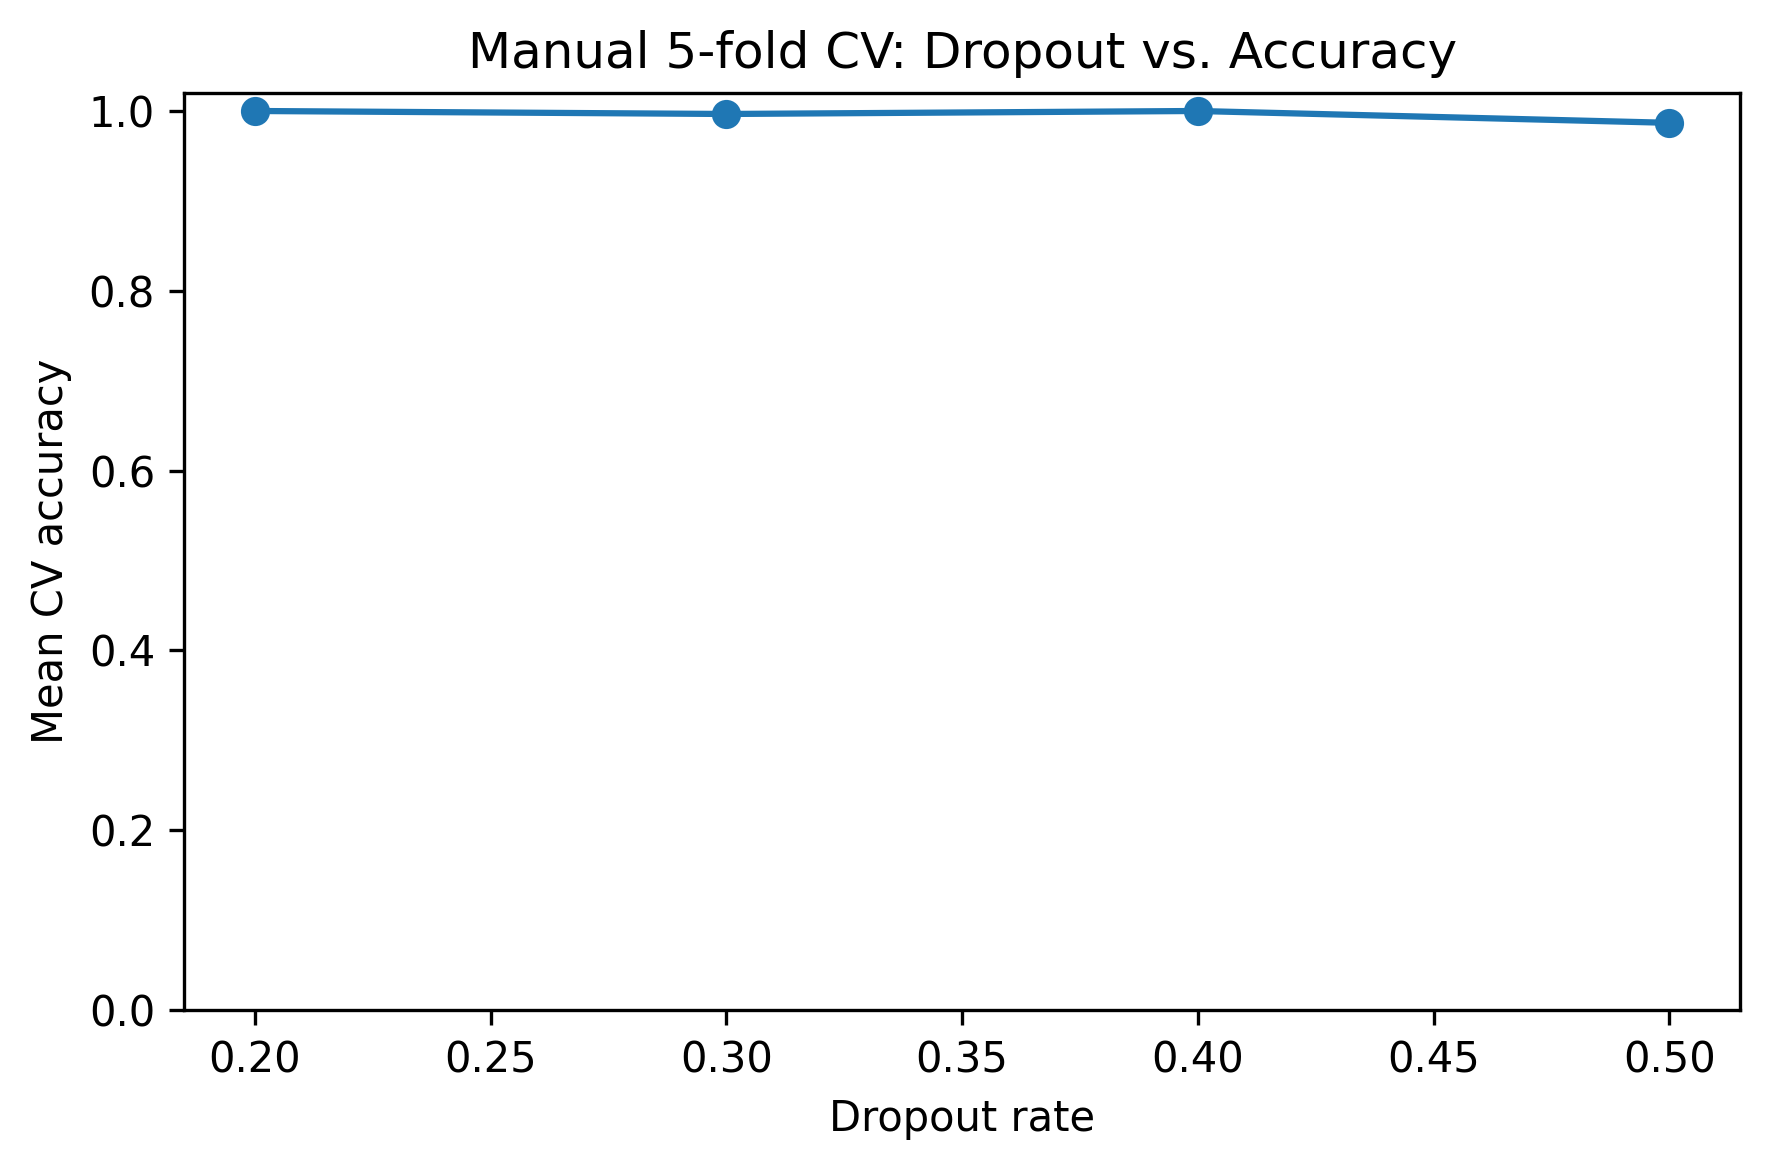


Best dropout rate: 0.2  (CV acc ≈ 1.0000)


In [38]:
# ─── 1) Prepare your 5-fold splitter ────────────────────────────────
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ─── 2) Hyperparameter grid ────────────────────────────────────────
drop_rates = [0.2, 0.3, 0.4, 0.5]
cv_test_scores = []

# ─── 3) Loop over each dropout rate ─────────────────────────────────
for dr in drop_rates:
    fold_scores = []
    for train_idx, val_idx in skf.split(X2, y2_int):
        X_tr, X_val = X2[train_idx], X2[val_idx]
        y_tr, y_val = y2_int[train_idx], y2_int[val_idx]

        # Build a fresh model for this fold
        model = Sequential([
            Input(shape=(X2.shape[1],)),
            Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(dr),
            Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
            Dropout(dr),
            Dense(len(np.unique(y2_int)), activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        # EarlyStopping on this fold’s validation set
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

        # Train (we’ll use the fold’s split as training/validation directly)
        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=50,
            batch_size=16,
            callbacks=[es],
            verbose=0
        )

        # Evaluate on this fold’s validation set
        loss, acc = model.evaluate(X_val, y_val, verbose=0)
        fold_scores.append(acc)

    # Average CV accuracy for this dropout rate
    cv_test_scores.append(np.mean(fold_scores))
    print(f"Dropout {dr:.1f} → CV accuracy: {np.mean(fold_scores):.4f} ± {np.std(fold_scores):.4f}")

# ─── 4) Plot dropout vs. CV acc ────────────────────────────────────
plt.figure(figsize=(8,6))
plt.plot(drop_rates, cv_test_scores, marker='o-', label="Test Scores")
plt.xlabel("Dropout rate")
plt.ylabel("Mean CV accuracy")
plt.title("Manual 5-fold CV: Dropout vs. Accuracy")
plt.ylim(0,1.02)
# plt.grid(True)
plt.tight_layout()
plt.savefig('./Plots/NeuralNet/dropout_vs_accuracy.pdf')
plt.show()

# ─── 5) Report best dropout ────────────────────────────────────────
best_idx = int(np.argmax(cv_test_scores))
best_dr = drop_rates[best_idx]
print(f"\nBest dropout rate: {best_dr:.1f}  (CV acc ≈ {cv_test_scores[best_idx]:.4f})")


### **Full Parameter GridSearch**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks    import EarlyStopping

from sklearn.base             import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics          import accuracy_score
# ─── 1) A sklearn-style wrapper for your Keras network ────────────────────
class KerasNN(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 activation='relu',
                 layer1=64,
                 layer2=32,
                 dropout=0.5,
                 l2_reg=0.001,
                 batch_size=16,
                 epochs=50,
                 random_state=42):
        self.activation  = activation
        self.layer1      = layer1
        self.layer2      = layer2
        self.dropout     = dropout
        self.l2_reg      = l2_reg
        self.batch_size  = batch_size
        self.epochs      = epochs
        self.random_state= random_state
        self.model       = None

    def _build_model(self, input_dim, n_classes):
        """(Re)build the Keras model using current hyperparameters."""
        tf.keras.utils.set_random_seed(self.random_state)
        m = Sequential([
            Input(shape=(input_dim,)),
            Dense(self.layer1, activation=self.activation,
                  kernel_regularizer=l2(self.l2_reg)),
            Dropout(self.dropout),
            Dense(self.layer2, activation=self.activation,
                  kernel_regularizer=l2(self.l2_reg)),
            Dropout(self.dropout),
            Dense(n_classes, activation='softmax')
        ])
        m.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return m

    def fit(self, X, y):
        n_classes = len(np.unique(y))
        input_dim = X.shape[1]
        self.model = self._build_model(input_dim, n_classes)
        # EarlyStopping on a 20% holdout from the X/y passed to fit()
        es = EarlyStopping(monitor='val_loss', patience=5,
                           restore_best_weights=True, verbose=0)
        self.model.fit(
            X, y,
            validation_split=0.30,
            epochs=self.epochs,
            batch_size=self.batch_size,
            callbacks=[es],
            verbose=0
        )
        return self

    def predict(self, X):
        proba = self.model.predict(X, verbose=0)
        return np.argmax(proba, axis=1)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

param_grid = {
    'activation':  ['relu','tanh'],
    'layer1':      [32, 64, 128],
    'layer2':      [16, 32, 64],
    'dropout':     [0.2],
    'l2_reg':      [0.0, 1e-3],
    'batch_size':  [16],     # fix to 16 for speed
    'epochs':      [50],     # fix to 50 for speed
}

grid = GridSearchCV(
    estimator=KerasNN(),
    param_grid=param_grid,
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    scoring='accuracy',
    verbose=2,
    n_jobs=1
)

grid.fit(X2, y2_int)

print("Best params:", grid.best_params_)
print("Best CV acc:", grid.best_score_)
